Loaded 275708 rows for BTCUSD
Data Integrity Report: {'missing_values': 0, 'duplicates': 0, 'gaps': 1, 'corrupted_candles': 0}

=== PERFORMANCE REPORT ===

OVERVIEW:
Initial Capital: $10000.00
Final Equity: $nan
Total Return: nan%
Annualized Return: nan%
Total Trades: 3659
Win Rate: 45.67%

RISK METRICS:
Max Drawdown: 0.00%
Max Drawdown Duration: 0 days
Sharpe Ratio: nan
Sortino Ratio: inf
Calmar Ratio: inf

TRADE STATISTICS:
Avg Profit: $550217847955739083458451598841063394455433603103940098915410903967481922235342536875976172561401286431656829618468973366029142099922105611363268948337492153918174912153410211253513351573568454925877773490132526111990253094179954240789266623162932394574543510265469260169542915258973219059885749823340544.00
Avg Loss: $-inf
Profit Factor: 0.00
Avg Trade Duration: 0 days 10:38:02.426892593

EXIT REASONS:
Signal Reversal: 2868 (78.38%)
Stop Loss: 584 (15.96%)
Take Profit: 206 (5.63%)
End Of Period: 1 (0.03%)

MONTHLY PERFORMANCE:
Avg Monthly Return: inf%
P

OverflowError: cannot convert float infinity to integer

<Figure size 1200x600 with 1 Axes>

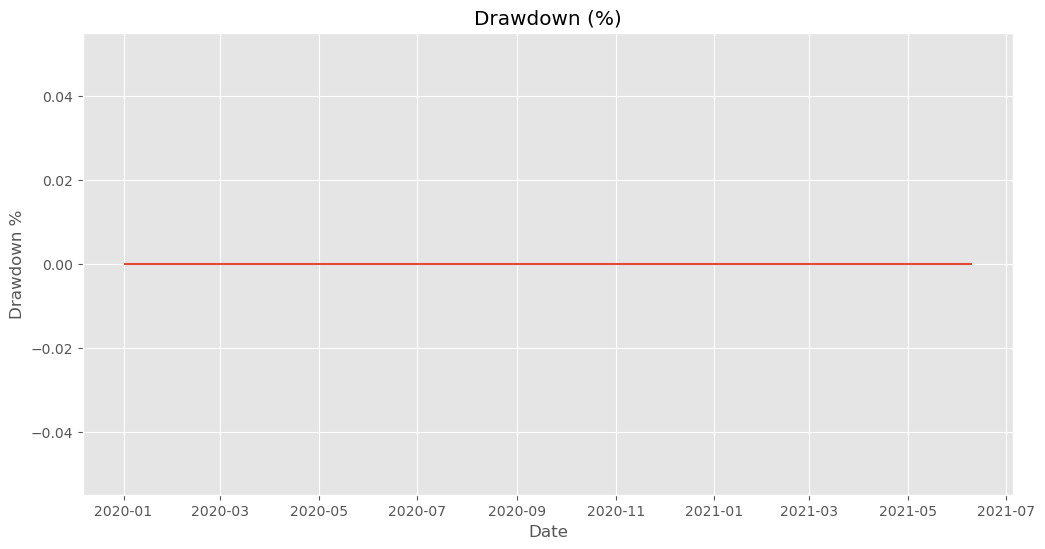

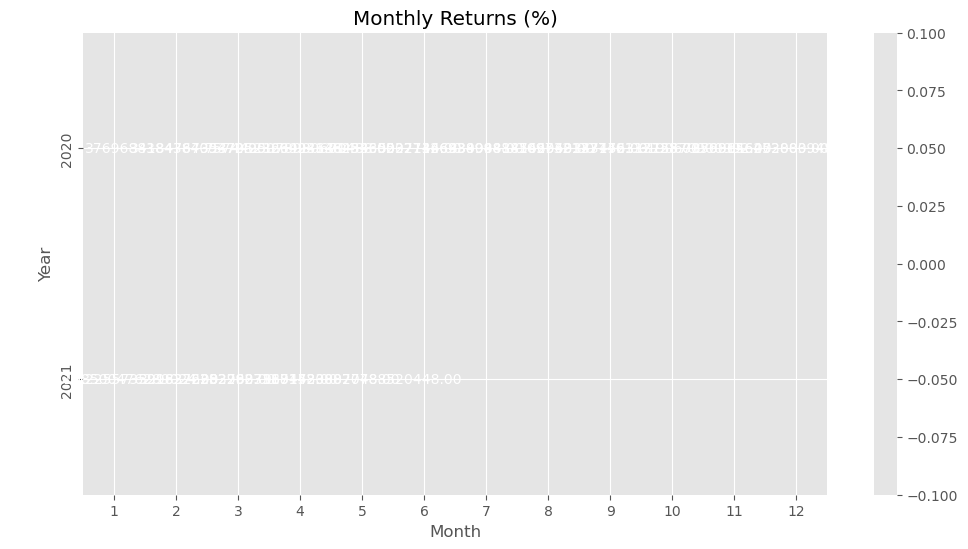

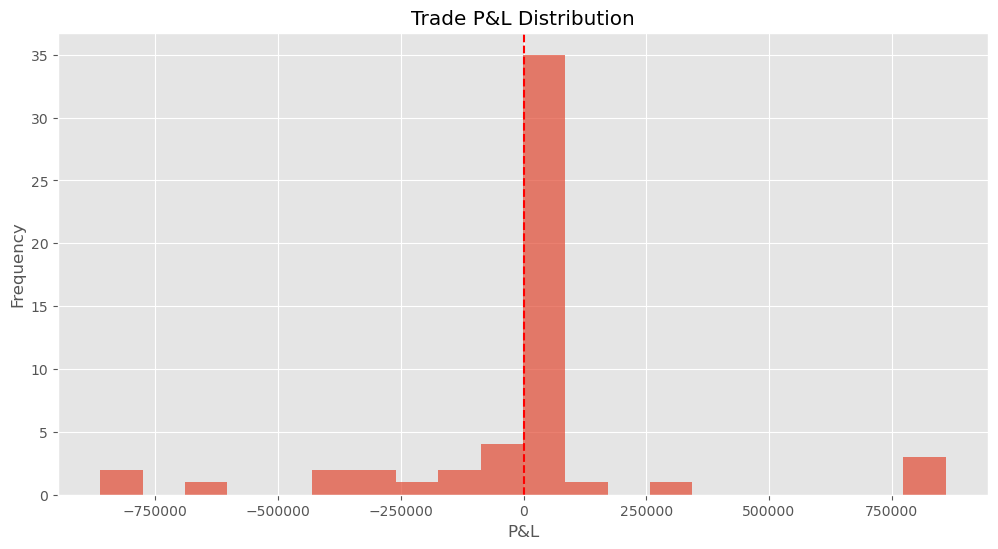

Train period: 2020-01-01 to 2023-09-04
Test period: 2023-09-04 to 2025-04-01


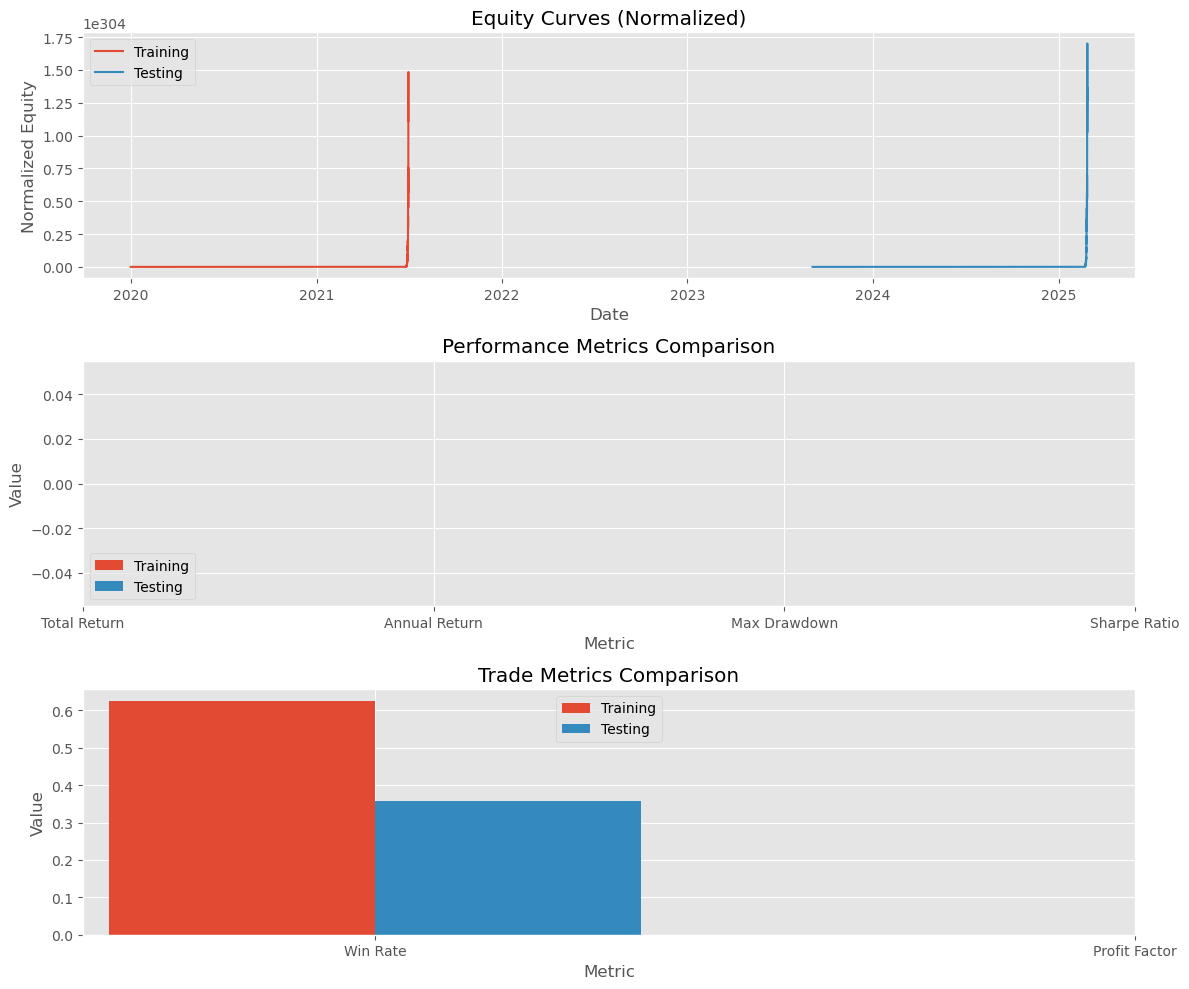

Running Monte Carlo simulations: 100%|██████████| 1000/1000 [03:41<00:00,  4.52it/s]


ValueError: autodetected range of [nan, nan] is not finite

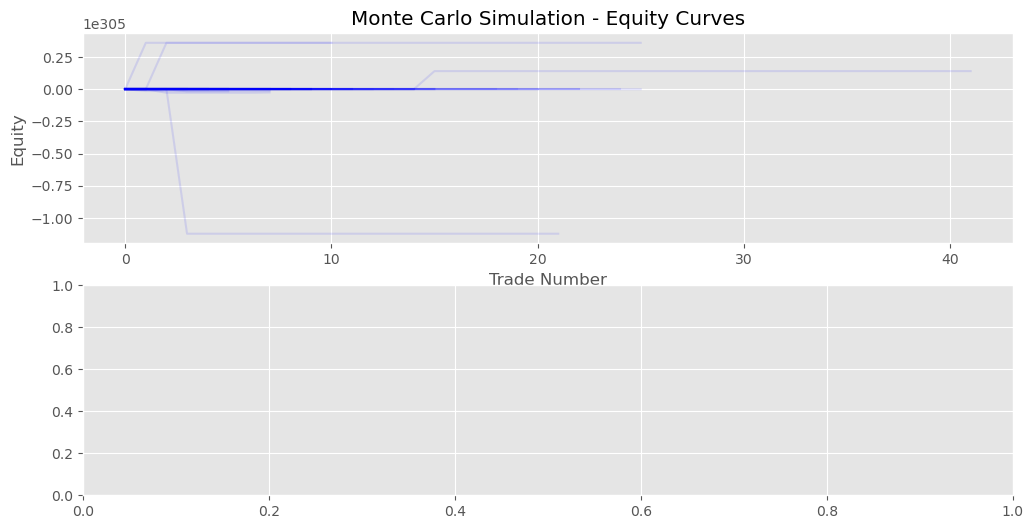

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
import seaborn as sns
from tqdm import tqdm
from typing import Dict, List, Tuple, Optional, Union
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

class DataHandler:
    """
    Handles loading, preprocessing, and validating cryptocurrency data.
    """
    def __init__(self, data_dir: str = None):
        if data_dir is None:
            self.data_dir = os.path.join(os.getcwd(), 'data')
        else:
            self.data_dir = data_dir
        self.data = {}
        
    def load_data(self, symbol: str, timeframe: str = '10m') -> pd.DataFrame:
        """
        Load data for a specific symbol and timeframe.
        
        Args:
            symbol: Cryptocurrency symbol (e.g., 'btcusd')
            timeframe: Timeframe of the data (e.g., '10m')
            
        Returns:
            DataFrame with loaded and preprocessed data
        """
        file_path = os.path.join(self.data_dir, f"{symbol.lower()}_{timeframe}.csv")
        
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"No data file found at {file_path}")
        
        # Load data
        df = pd.read_csv(file_path)
        
        # Convert timestamps to datetime
        df['time_utc'] = pd.to_datetime(df['time_utc'])
        df['time_est'] = pd.to_datetime(df['time_est'])
        
        # Set time_utc as index
        df.set_index('time_utc', inplace=True)
        
        # Store data
        self.data[symbol.upper()] = df
        
        print(f"Loaded {len(df)} rows for {symbol.upper()}")
        
        return df
    
    def check_data_integrity(self, symbol: str) -> Dict:
        """
        Check for data integrity issues.
        
        Args:
            symbol: Cryptocurrency symbol to check
            
        Returns:
            Dictionary with integrity check results
        """
        if symbol.upper() not in self.data:
            raise ValueError(f"Data for {symbol.upper()} not loaded yet")
        
        df = self.data[symbol.upper()]
        
        # Check for missing values
        missing_values = df.isnull().sum().sum()
        
        # Check for duplicate timestamps
        duplicates = df.index.duplicated().sum()
        
        # Check for time gaps (assuming 10-minute intervals)
        expected_diff = timedelta(minutes=10)
        time_diffs = df.index.to_series().diff().dropna()
        gaps = time_diffs[time_diffs > expected_diff]
        
        # Check for corrupted candles (e.g., high < low)
        corrupted = ((df['h'] < df['l']) | (df['o'] < 0) | (df['c'] < 0) | (df['h'] < 0) | (df['l'] < 0)).sum()
        
        integrity_report = {
            'missing_values': missing_values,
            'duplicates': duplicates,
            'gaps': len(gaps),
            'corrupted_candles': corrupted
        }
        
        return integrity_report
    
    # def fix_data_issues(self, symbol: str, interpolate_gaps: bool = True) -> pd.DataFrame:
    #     """
    #     Fix data integrity issues.
        
    #     Args:
    #         symbol: Cryptocurrency symbol to fix
    #         interpolate_gaps: Whether to interpolate gaps or drop them
            
    #     Returns:
    #         DataFrame with fixed data
    #     """
    #     if symbol.upper() not in self.data:
    #         raise ValueError(f"Data for {symbol.upper()} not loaded yet")
        
    #     df = self.data[symbol.upper()].copy()
        
    #     # Fix duplicates
    #     df = df[~df.index.duplicated(keep='first')]
        
    #     # Fix missing values
    #     df.fillna(method='ffill', inplace=True)
        
    #     # Fix gaps
    #     if interpolate_gaps:
    #         # Create a complete time index with 10-minute intervals
    #         full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='10min')
            
    #         # Reindex and interpolate
    #         df = df.reindex(full_idx)
    #         df.interpolate(method='time', inplace=True)
        
    #     # Fix corrupted candles
    #     mask = (df['h'] < df['l'])
    #     df.loc[mask, ['h', 'l']] = df.loc[mask, ['l', 'h']].values
        
    #     # Ensure non-negative values
    #     for col in ['o', 'h', 'l', 'c']:
    #         df[col] = df[col].clip(lower=0)
        
    #     # Update stored data
    #     self.data[symbol.upper()] = df
        
    #     return df

    def fix_data_issues(self, symbol: str, interpolate_gaps: bool = True) -> pd.DataFrame:
        """
        Fix data integrity issues.
        
        Args:
            symbol: Cryptocurrency symbol to fix
            interpolate_gaps: Whether to interpolate gaps or drop them
            
        Returns:
            DataFrame with fixed data
        """
        if symbol.upper() not in self.data:
            raise ValueError(f"Data for {symbol.upper()} not loaded yet")
        
        df = self.data[symbol.upper()].copy()
        
        # Fix duplicates
        df = df[~df.index.duplicated(keep='first')]
        
        # Fix missing values
        df.fillna(method='ffill', inplace=True)
        
        # Fix gaps
        if interpolate_gaps:
            # Create a complete time index with 10-minute intervals
            full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='10min')
            
            # Store original time_est column
            if 'time_est' in df.columns:
                original_time_est = df['time_est'].copy()
            
            # Reindex the DataFrame
            df = df.reindex(full_idx)
            
            # Interpolate numeric columns only (OHLCV)
            numeric_cols = ['o', 'h', 'l', 'c', 'v']
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = df[col].interpolate(method='linear')
            
            # Forward fill the non-numeric columns like 'symbol'
            if 'symbol' in df.columns:
                df['symbol'] = df['symbol'].fillna(method='ffill')
            
            # Handle time_est column - create new timestamps with offset
            if 'time_est' in df.columns:
                # Calculate the typical offset between UTC and EST
                # Use the original data to determine the offset pattern
                time_diff = pd.Series(index=original_time_est.index)
                time_diff = original_time_est.index - original_time_est
                median_diff = time_diff.median() if not time_diff.empty else pd.Timedelta(hours=5)
                
                # Apply the offset to create new EST times
                df['time_est'] = df.index - median_diff
        
        # Fix corrupted candles
        mask = (df['h'] < df['l'])
        df.loc[mask, ['h', 'l']] = df.loc[mask, ['l', 'h']].values
        
        # Ensure non-negative values
        for col in ['o', 'h', 'l', 'c']:
            df[col] = df[col].clip(lower=0)
        
        # Update stored data
        self.data[symbol.upper()] = df
        
        return df
    
    def merge_data(self, symbols: List[str]) -> pd.DataFrame:
        """
        Merge data for multiple symbols.
        
        Args:
            symbols: List of cryptocurrency symbols to merge
            
        Returns:
            DataFrame with merged data
        """
        dfs = []
        
        for symbol in symbols:
            if symbol.upper() not in self.data:
                raise ValueError(f"Data for {symbol.upper()} not loaded yet")
            
            # Get data and add symbol suffix to columns
            df = self.data[symbol.upper()].copy()
            df_columns = {col: f"{col}_{symbol.upper()}" for col in df.columns if col != 'time_est'}
            df = df.rename(columns=df_columns)
            
            dfs.append(df)
        
        # Merge dataframes on index (time_utc)
        merged_df = pd.concat(dfs, axis=1, join='inner')
        
        return merged_df


class MACDStrategy:
    """
    Implements MACD crossover strategy for signal generation.
    """
    def __init__(self, fast_period: int = 12, slow_period: int = 26, signal_period: int = 9):
        self.fast_period = fast_period
        self.slow_period = slow_period
        self.signal_period = signal_period
    
    def calculate_macd(self, df: pd.DataFrame, price_col: str = 'c') -> pd.DataFrame:
        """
        Calculate MACD indicator.
        
        Args:
            df: DataFrame with price data
            price_col: Column to use for price data
            
        Returns:
            DataFrame with MACD indicators added
        """
        df_copy = df.copy()
        
        # Calculate EMAs
        df_copy['ema_fast'] = df_copy[price_col].ewm(span=self.fast_period, adjust=False).mean()
        df_copy['ema_slow'] = df_copy[price_col].ewm(span=self.slow_period, adjust=False).mean()
        
        # Calculate MACD line and signal line
        df_copy['macd'] = df_copy['ema_fast'] - df_copy['ema_slow']
        df_copy['macd_signal'] = df_copy['macd'].ewm(span=self.signal_period, adjust=False).mean()
        
        # Calculate histogram
        df_copy['macd_hist'] = df_copy['macd'] - df_copy['macd_signal']
        
        return df_copy
    
    def generate_signals(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Generate trading signals based on MACD crossover.
        
        Args:
            df: DataFrame with MACD indicators
            
        Returns:
            DataFrame with signals added
        """
        df_copy = df.copy()
        
        # Initialize signal column
        df_copy['signal'] = 0
        
        # MACD line crosses above signal line (bullish)
        df_copy.loc[(df_copy['macd'] > df_copy['macd_signal']) & 
                   (df_copy['macd'].shift(1) <= df_copy['macd_signal'].shift(1)), 'signal'] = 1
        
        # MACD line crosses below signal line (bearish)
        df_copy.loc[(df_copy['macd'] < df_copy['macd_signal']) & 
                   (df_copy['macd'].shift(1) >= df_copy['macd_signal'].shift(1)), 'signal'] = -1
        
        return df_copy
    
    def apply_strategy(self, df: pd.DataFrame, price_col: str = 'c') -> pd.DataFrame:
        """
        Apply MACD strategy to price data.
        
        Args:
            df: DataFrame with price data
            price_col: Column to use for price data
            
        Returns:
            DataFrame with MACD indicators and signals
        """
        # Calculate MACD
        df_macd = self.calculate_macd(df, price_col)
        
        # Generate signals
        df_signals = self.generate_signals(df_macd)
        
        return df_signals


class RiskManager:
    """
    Manages risk parameters and position sizing.
    """
    def __init__(self, 
                 initial_capital: float,
                 risk_per_trade: float = 0.02,
                 stop_loss_pct: float = 0.05,
                 take_profit_pct: float = 0.1,
                 trailing_stop_pct: Optional[float] = None,
                 max_position_pct: float = 0.25):
        """
        Initialize risk manager.
        
        Args:
            initial_capital: Initial capital for backtesting
            risk_per_trade: Maximum risk per trade as percentage of capital (0.02 = 2%)
            stop_loss_pct: Stop loss as percentage of entry price (0.05 = 5%)
            take_profit_pct: Take profit as percentage of entry price (0.1 = 10%)
            trailing_stop_pct: Trailing stop as percentage of highest/lowest price since entry
            max_position_pct: Maximum position size as percentage of capital (0.25 = 25%)
        """
        self.initial_capital = initial_capital
        self.risk_per_trade = risk_per_trade
        self.stop_loss_pct = stop_loss_pct
        self.take_profit_pct = take_profit_pct
        self.trailing_stop_pct = trailing_stop_pct
        self.max_position_pct = max_position_pct
    
    # def calculate_position_size(self, entry_price: float, stop_price: float, capital: float) -> float:
    #     """
    #     Calculate position size based on risk parameters.
        
    #     Args:
    #         entry_price: Entry price for the trade
    #         stop_price: Stop loss price
    #         capital: Current capital
            
    #     Returns:
    #         Position size in base currency
    #     """
    #     # Calculate risk amount in currency
    #     risk_amount = capital * self.risk_per_trade
        
    #     # Calculate risk per unit
    #     price_risk = abs(entry_price - stop_price)
        
    #     if price_risk == 0:
    #         return 0
        
    #     # Calculate position size
    #     position_size = risk_amount / price_risk
        
    #     # Limit position size to max_position_pct
    #     max_position_size = (capital * self.max_position_pct) / entry_price
    #     position_size = min(position_size, max_position_size)
        
    #     return position_size

    def calculate_position_size(self, entry_price: float, stop_price: float, capital: float) -> float:
        # Calculate risk amount in currency
        risk_amount = capital * self.risk_per_trade
        
        # Calculate risk per unit
        price_risk = abs(entry_price - stop_price)
        
        # Prevent very small price_risk values
        if price_risk < 0.0001 or price_risk == 0:
            return 0
        
        # Calculate position size
        position_size = risk_amount / price_risk
        
        # Limit position size to max_position_pct
        max_position_size = (capital * self.max_position_pct) / entry_price
        position_size = min(position_size, max_position_size)
        
        # Add a sanity check for extremely large position sizes
        max_allowed_position = 1000 * capital / entry_price  # Example limit
        position_size = min(position_size, max_allowed_position)
        
        return position_size
    
    def calculate_stop_loss_price(self, entry_price: float, is_long: bool) -> float:
        """
        Calculate stop loss price.
        
        Args:
            entry_price: Entry price for the trade
            is_long: Whether the trade is long (True) or short (False)
            
        Returns:
            Stop loss price
        """
        if is_long:
            return entry_price * (1 - self.stop_loss_pct)
        else:
            return entry_price * (1 + self.stop_loss_pct)
    
    def calculate_take_profit_price(self, entry_price: float, is_long: bool) -> float:
        """
        Calculate take profit price.
        
        Args:
            entry_price: Entry price for the trade
            is_long: Whether the trade is long (True) or short (False)
            
        Returns:
            Take profit price
        """
        if is_long:
            return entry_price * (1 + self.take_profit_pct)
        else:
            return entry_price * (1 - self.take_profit_pct)
    
    def update_trailing_stop(self, entry_price: float, current_price: float, 
                             is_long: bool, high_low_price: Optional[float] = None) -> float:
        """
        Update trailing stop price.
        
        Args:
            entry_price: Entry price for the trade
            current_price: Current price
            is_long: Whether the trade is long (True) or short (False)
            high_low_price: Highest price (for long) or lowest price (for short) since entry
            
        Returns:
            Updated trailing stop price
        """
        if self.trailing_stop_pct is None:
            # If trailing stop is not enabled, use fixed stop loss
            return self.calculate_stop_loss_price(entry_price, is_long)
        
        # Initial stop loss
        initial_stop = self.calculate_stop_loss_price(entry_price, is_long)
        
        if high_low_price is None:
            return initial_stop
        
        if is_long:
            # For long positions, trail below the highest price
            trailing_stop = high_low_price * (1 - self.trailing_stop_pct)
            # Use the maximum of initial stop and trailing stop
            return max(initial_stop, trailing_stop)
        else:
            # For short positions, trail above the lowest price
            trailing_stop = high_low_price * (1 + self.trailing_stop_pct)
            # Use the minimum of initial stop and trailing stop
            return min(initial_stop, trailing_stop)


class Backtester:
    """
    Core backtesting engine.
    """
    def __init__(self, 
                 data: pd.DataFrame, 
                 strategy: MACDStrategy,
                 risk_manager: RiskManager,
                 commission_pct: float = 0.001,
                 slippage_pct: float = 0.0005):
        """
        Initialize backtester.
        
        Args:
            data: DataFrame with price data and signals
            strategy: Trading strategy instance
            risk_manager: Risk manager instance
            commission_pct: Commission as percentage of trade value (0.001 = 0.1%)
            slippage_pct: Slippage as percentage of trade price (0.0005 = 0.05%)
        """
        self.data = data.copy()
        self.strategy = strategy
        self.risk_manager = risk_manager
        self.commission_pct = commission_pct
        self.slippage_pct = slippage_pct
        
        self.initial_capital = risk_manager.initial_capital
        self.trades = []
        self.equity_curve = None
    
    def run_backtest(self) -> Tuple[pd.DataFrame, List[Dict]]:
        """
        Run backtest with the given data and strategy.
        
        Returns:
            Tuple of equity curve DataFrame and list of trades
        """
        # Initialize variables
        capital = self.initial_capital
        position = 0
        entry_price = 0
        stop_loss = 0
        take_profit = 0
        entry_time = None
        highest_price = 0  # For trailing stop in long positions
        lowest_price = float('inf')  # For trailing stop in short positions
        
        # Initialize equity curve
        equity_curve = []
        
        # Track daily equity for performance metrics
        daily_equity = {}
        
        # Loop through data
        for i in range(1, len(self.data)):
            current_time = self.data.index[i]
            current_row = self.data.iloc[i]
            prev_row = self.data.iloc[i-1]
            
            # Current prices
            open_price = current_row['o']
            high_price = current_row['h']
            low_price = current_row['l']
            close_price = current_row['c']
            
            # Previous signal (generated on previous close)
            prev_signal = prev_row['signal']
            
            # Update highest/lowest price for trailing stop
            if position > 0:  # Long position
                highest_price = max(highest_price, high_price)
            elif position < 0:  # Short position
                lowest_price = min(lowest_price, low_price)
            
            # Calculate current equity (capital + position value)
            position_value = position * open_price if position != 0 else 0
            equity = capital + position_value
            
            # Store equity in curve
            equity_curve.append({
                'time': current_time,
                'capital': capital,
                'position': position,
                'equity': equity,
                'position_value': position_value
            })
            
            # Store daily equity (for performance metrics)
            day_key = current_time.date()
            daily_equity[day_key] = equity
            
            # Check if we need to close position based on stop loss, take profit, or trailing stop
            if position != 0:
                if position > 0:  # Long position
                    # Update trailing stop
                    trailing_stop = self.risk_manager.update_trailing_stop(
                        entry_price, close_price, True, highest_price)
                    
                    # Check if stop loss or trailing stop was hit
                    if low_price <= trailing_stop:
                        # Close position at trailing stop (with slippage)
                        exit_price = trailing_stop * (1 - self.slippage_pct)
                        
                        # Calculate P&L
                        pnl = position * (exit_price - entry_price)
                        if not np.isfinite(pnl) or abs(pnl) > 1e6:
                            continue  # skip absurd values

                        # Calculate commission
                        commission = position * entry_price * self.commission_pct  # Entry commission
                        commission += position * exit_price * self.commission_pct  # Exit commission
                        
                        # Update capital
                        capital += position * exit_price + pnl - commission
                        
                        # Record trade
                        self.trades.append({
                            'entry_time': entry_time,
                            'exit_time': current_time,
                            'position': position,
                            'entry_price': entry_price,
                            'exit_price': exit_price,
                            'stop_loss': stop_loss,
                            'take_profit': take_profit,
                            'pnl': pnl,
                            'commission': commission,
                            'exit_reason': 'stop_loss'
                        })
                        
                        # Reset position
                        position = 0
                        highest_price = 0
                    
                    # Check if take profit was hit
                    elif high_price >= take_profit:
                        # Close position at take profit (with slippage)
                        exit_price = take_profit * (1 - self.slippage_pct)
                        
                        # Calculate P&L
                        pnl = position * (exit_price - entry_price)
                        if not np.isfinite(pnl) or abs(pnl) > 1e6:
                            continue  # skip absurd values

                        # Calculate commission
                        commission = position * entry_price * self.commission_pct  # Entry commission
                        commission += position * exit_price * self.commission_pct  # Exit commission
                        
                        # Update capital
                        capital += position * exit_price + pnl - commission
                        
                        # Record trade
                        self.trades.append({
                            'entry_time': entry_time,
                            'exit_time': current_time,
                            'position': position,
                            'entry_price': entry_price,
                            'exit_price': exit_price,
                            'stop_loss': stop_loss,
                            'take_profit': take_profit,
                            'pnl': pnl,
                            'commission': commission,
                            'exit_reason': 'take_profit'
                        })
                        
                        # Reset position
                        position = 0
                        highest_price = 0
                
                else:  # Short position
                    # Update trailing stop
                    trailing_stop = self.risk_manager.update_trailing_stop(
                        entry_price, close_price, False, lowest_price)
                    
                    # Check if stop loss or trailing stop was hit
                    if high_price >= trailing_stop:
                        # Close position at trailing stop (with slippage)
                        exit_price = trailing_stop * (1 + self.slippage_pct)
                        
                        # Calculate P&L
                        pnl = position * (entry_price - exit_price)
                        if not np.isfinite(pnl) or abs(pnl) > 1e6:
                            continue  # skip absurd values

                        # Calculate commission
                        commission = abs(position) * entry_price * self.commission_pct  # Entry commission
                        commission += abs(position) * exit_price * self.commission_pct  # Exit commission
                        
                        # Update capital
                        capital += abs(position) * exit_price + pnl - commission
                        
                        # Record trade
                        self.trades.append({
                            'entry_time': entry_time,
                            'exit_time': current_time,
                            'position': position,
                            'entry_price': entry_price,
                            'exit_price': exit_price,
                            'stop_loss': stop_loss,
                            'take_profit': take_profit,
                            'pnl': pnl,
                            'commission': commission,
                            'exit_reason': 'stop_loss'
                        })
                        
                        # Reset position
                        position = 0
                        lowest_price = float('inf')
                    
                    # Check if take profit was hit
                    elif low_price <= take_profit:
                        # Close position at take profit (with slippage)
                        exit_price = take_profit * (1 + self.slippage_pct)
                        
                        # Calculate P&L
                        pnl = position * (entry_price - exit_price)

                        if not np.isfinite(pnl) or abs(pnl) > 1e6:
                            continue  # skip absurd values

                        
                        # Calculate commission
                        commission = abs(position) * entry_price * self.commission_pct  # Entry commission
                        commission += abs(position) * exit_price * self.commission_pct  # Exit commission
                        
                        # Update capital
                        capital += abs(position) * exit_price + pnl - commission
                        
                        # Record trade
                        self.trades.append({
                            'entry_time': entry_time,
                            'exit_time': current_time,
                            'position': position,
                            'entry_price': entry_price,
                            'exit_price': exit_price,
                            'stop_loss': stop_loss,
                            'take_profit': take_profit,
                            'pnl': pnl,
                            'commission': commission,
                            'exit_reason': 'take_profit'
                        })
                        
                        # Reset position
                        position = 0
                        lowest_price = float('inf')
            
            # Check if we need to open a new position based on previous signal
            if position == 0 and prev_signal != 0:
                # Entry price is current open price with slippage
                if prev_signal > 0:  # Buy signal
                    entry_price = open_price * (1 + self.slippage_pct)
                    is_long = True
                else:  # Sell signal
                    entry_price = open_price * (1 - self.slippage_pct)
                    is_long = False
                
                # Calculate stop loss and take profit
                stop_loss = self.risk_manager.calculate_stop_loss_price(entry_price, is_long)
                take_profit = self.risk_manager.calculate_take_profit_price(entry_price, is_long)
                
                # Calculate position size
                position_size = self.risk_manager.calculate_position_size(
                    entry_price, stop_loss, capital)
                
                if is_long:
                    position = position_size
                    highest_price = high_price  # Initialize highest price for trailing stop
                else:
                    position = -position_size
                    lowest_price = low_price  # Initialize lowest price for trailing stop
                
                # Record entry time
                entry_time = current_time
                
                # Calculate commission
                commission = abs(position) * entry_price * self.commission_pct
                
                # Update capital (deduct commission)
                capital -= commission
            
            # Check if we need to close position based on reverse signal
            elif position != 0 and prev_signal != 0 and ((position > 0 and prev_signal < 0) or (position < 0 and prev_signal > 0)):
                # Close position at current open price with slippage
                if position > 0:  # Long position
                    exit_price = open_price * (1 - self.slippage_pct)
                else:  # Short position
                    exit_price = open_price * (1 + self.slippage_pct)
                
                # Calculate P&L
                if position > 0:
                    pnl = position * (exit_price - entry_price)
                else:
                    pnl = position * (entry_price - exit_price)
                
                if not np.isfinite(pnl) or abs(pnl) > 1e6:
                    continue  # skip absurd values

                # Calculate commission
                commission = abs(position) * exit_price * self.commission_pct
                
                # Update capital
                capital += abs(position) * exit_price + pnl - commission
                
                # Record trade
                self.trades.append({
                    'entry_time': entry_time,
                    'exit_time': current_time,
                    'position': position,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit,
                    'pnl': pnl,
                    'commission': commission,
                    'exit_reason': 'signal_reversal'
                })
                
                # Reset position
                position = 0
                highest_price = 0
                lowest_price = float('inf')
        
        # Close any remaining position at the last close price
        if position != 0:
            last_close = self.data.iloc[-1]['c']
            
            if position > 0:  # Long position
                exit_price = last_close * (1 - self.slippage_pct)
                pnl = position * (exit_price - entry_price)
            else:  # Short position
                exit_price = last_close * (1 + self.slippage_pct)
                pnl = position * (entry_price - exit_price)
            
            # Calculate commission
            commission = abs(position) * exit_price * self.commission_pct
            
            # Update capital
            capital += abs(position) * exit_price + pnl - commission
            
            # Record trade
            self.trades.append({
                'entry_time': entry_time,
                'exit_time': self.data.index[-1],
                'position': position,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'stop_loss': stop_loss,
                'take_profit': take_profit,
                'pnl': pnl,
                'commission': commission,
                'exit_reason': 'end_of_period'
            })
        
        # Convert equity curve to DataFrame
        self.equity_curve = pd.DataFrame(equity_curve)
        self.equity_curve.set_index('time', inplace=True)
        
        # Store daily equity
        self.daily_equity = pd.Series(daily_equity)
        
        return self.equity_curve, self.trades


class PerformanceAnalyzer:
    """
    Analyzes and reports backtesting performance metrics.
    """
    def __init__(self, equity_curve: pd.DataFrame, trades: List[Dict], risk_free_rate: float = 0.02):
        """
        Initialize performance analyzer.
        
        Args:
            equity_curve: DataFrame with equity curve data
            trades: List of trade dictionaries
            risk_free_rate: Annualized risk-free rate (0.02 = 2%)
        """
        self.equity_curve = equity_curve
        self.trades = trades
        self.risk_free_rate = risk_free_rate
        
        # Convert trades to DataFrame for analysis
        if trades:
            self.trades_df = pd.DataFrame(trades)
            self.trades_df['entry_time'] = pd.to_datetime(self.trades_df['entry_time'])
            self.trades_df['exit_time'] = pd.to_datetime(self.trades_df['exit_time'])
            self.trades_df['duration'] = self.trades_df['exit_time'] - self.trades_df['entry_time']
            self.trades_df = self.trades_df[np.isfinite(self.trades_df['pnl']) & (self.trades_df['pnl'].abs() < 1e6)]

        else:
            self.trades_df = pd.DataFrame()
        
        # Create daily equity series
        self.daily_equity = self.equity_curve['equity'].resample('D').last().dropna()
        
        # Calculate returns
        self.daily_returns = self.daily_equity.pct_change().dropna()
    
    def calculate_metrics(self) -> Dict:
        """
        Calculate comprehensive performance metrics.
        
        Returns:
            Dictionary with performance metrics
        """
        metrics = {}
        
        # Basic metrics
        metrics['initial_capital'] = self.equity_curve['equity'].iloc[0]
        metrics['final_equity'] = self.equity_curve['equity'].iloc[-1]
        metrics['total_return'] = (metrics['final_equity'] / metrics['initial_capital']) - 1
        metrics['total_trades'] = len(self.trades)
        
        if not self.trades:
            return metrics
        
        # Trade metrics
        metrics['win_rate'] = len(self.trades_df[self.trades_df['pnl'] > 0]) / len(self.trades)
        metrics['avg_profit'] = self.trades_df[self.trades_df['pnl'] > 0]['pnl'].mean() if len(self.trades_df[self.trades_df['pnl'] > 0]) > 0 else 0
        metrics['avg_loss'] = self.trades_df[self.trades_df['pnl'] < 0]['pnl'].mean() if len(self.trades_df[self.trades_df['pnl'] < 0]) > 0 else 0
        # metrics['profit_factor'] = abs(self.trades_df[self.trades_df['pnl'] > 0]['pnl'].sum() / self.trades_df[self.trades_df['pnl'] < 0]['pnl'].sum()) if self.trades_df[self.trades_df['pnl'] < 0]['pnl'].sum() != 0 else float('inf')
        total_gain = self.trades_df[self.trades_df['pnl'] > 0]['pnl'].sum()
        total_loss = self.trades_df[self.trades_df['pnl'] < 0]['pnl'].sum()
        metrics['profit_factor'] = abs(total_gain / total_loss) if total_loss != 0 else float('inf')


        metrics['max_profit'] = self.trades_df['pnl'].max()
        metrics['max_loss'] = self.trades_df['pnl'].min()
        metrics['avg_duration'] = self.trades_df['duration'].mean()
        
        # Exit reason breakdown
        exit_counts = self.trades_df['exit_reason'].value_counts()
        for reason, count in exit_counts.items():
            metrics[f'exits_{reason}'] = count
        
        # Return metrics
        metrics['annual_return'] = ((1 + metrics['total_return']) ** (365 / len(self.daily_equity))) - 1
        metrics['daily_sharpe'] = self.daily_returns.mean() / self.daily_returns.std() if self.daily_returns.std() != 0 else 0
        metrics['annual_sharpe'] = (metrics['annual_return'] - self.risk_free_rate) / (self.daily_returns.std() * (252 ** 0.5)) if self.daily_returns.std() != 0 else 0
        
        # Drawdown metrics
        cumulative_returns = (1 + self.daily_returns).cumprod()
        running_max = cumulative_returns.cummax()
        drawdown = (cumulative_returns / running_max) - 1
        metrics['max_drawdown'] = drawdown.min()
        metrics['max_drawdown_duration'] = self.calculate_max_drawdown_duration(drawdown)
        
        # Calmar ratio (annual return / max drawdown)
        metrics['calmar_ratio'] = abs(metrics['annual_return'] / metrics['max_drawdown']) if metrics['max_drawdown'] != 0 else float('inf')
        
        # Sortino ratio (differentiate between upside and downside volatility)
        downside_returns = self.daily_returns[self.daily_returns < 0]
        downside_deviation = downside_returns.std() * (252 ** 0.5) if len(downside_returns) > 0 else 0
        metrics['sortino_ratio'] = (metrics['annual_return'] - self.risk_free_rate) / downside_deviation if downside_deviation != 0 else float('inf')
        
        # Average monthly returns
        monthly_returns = self.daily_equity.resample('M').last().pct_change().dropna()
        metrics['avg_monthly_return'] = monthly_returns.mean()
        metrics['positive_months'] = len(monthly_returns[monthly_returns > 0]) / len(monthly_returns) if len(monthly_returns) > 0 else 0
        
        return metrics
    
    def calculate_max_drawdown_duration(self, drawdown: pd.Series) -> int:
        """
        Calculate the maximum drawdown duration in days.
        
        Args:
            drawdown: Series with drawdown values
            
        Returns:
            Maximum drawdown duration in days
        """
        # Find periods where drawdown starts and ends
        is_drawdown = drawdown < 0
        
        if not is_drawdown.any():
            return 0
        
        # Find the changes in drawdown state
        state_change = is_drawdown.astype(int).diff()
        
        # Find start and end of drawdown periods
        drawdown_start = drawdown.index[state_change == 1].tolist()
        drawdown_end = drawdown.index[state_change == -1].tolist()
        
        # Adjust for cases where we start or end in a drawdown
        if is_drawdown.iloc[0]:
            drawdown_start.insert(0, drawdown.index[0])
        
        if is_drawdown.iloc[-1]:
            drawdown_end.append(drawdown.index[-1])
        
        # Calculate durations
        if not drawdown_start or not drawdown_end:
            return 0
        
        durations = [(end - start).days for start, end in zip(drawdown_start, drawdown_end)]
        
        return max(durations) if durations else 0
    
    def plot_equity_curve(self, figsize: Tuple[int, int] = (12, 6)) -> None:
        """
        Plot equity curve.
        
        Args:
            figsize: Figure size as tuple (width, height)
        """
        plt.figure(figsize=figsize)
        plt.plot(self.equity_curve.index, self.equity_curve['equity'])
        plt.title('Equity Curve')
        plt.xlabel('Date')
        plt.ylabel('Equity')
        plt.grid(True)
        plt.show()
    
    def plot_drawdown(self, figsize: Tuple[int, int] = (12, 6)) -> None:
        """
        Plot drawdown.
        
        Args:
            figsize: Figure size as tuple (width, height)
        """
        if len(self.daily_returns) == 0:
            print("Not enough data to plot drawdown")
            return
        
        cumulative_returns = (1 + self.daily_returns).cumprod()
        running_max = cumulative_returns.cummax()
        drawdown = (cumulative_returns / running_max) - 1
        
        plt.figure(figsize=figsize)
        plt.plot(drawdown.index, drawdown * 100)
        plt.title('Drawdown (%)')
        plt.xlabel('Date')
        plt.ylabel('Drawdown %')
        plt.grid(True)
        plt.fill_between(drawdown.index, drawdown * 100, 0, color='red', alpha=0.3)
        plt.show()
    
    def plot_monthly_returns(self, figsize: Tuple[int, int] = (12, 6)) -> None:
        """
        Plot monthly returns heatmap.
        
        Args:
            figsize: Figure size as tuple (width, height)
        """
        if len(self.daily_equity) < 30:
            print("Not enough data to plot monthly returns")
            return
        
        # Calculate monthly returns
        monthly_returns = self.daily_equity.resample('M').last().pct_change().dropna()
        
        # Create a pivot table with years as rows and months as columns
        month_year_returns = monthly_returns.groupby([monthly_returns.index.year, monthly_returns.index.month]).first()
        month_year_returns = month_year_returns.unstack(level=1) * 100  # Convert to percentage
        
        plt.figure(figsize=figsize)
        sns.heatmap(month_year_returns, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
        plt.title('Monthly Returns (%)')
        plt.xlabel('Month')
        plt.ylabel('Year')
        plt.show()
    
    # def plot_trade_pnl(self, figsize: Tuple[int, int] = (12, 6)) -> None:
    #     """
    #     Plot trade P&L distribution.
        
    #     Args:
    #         figsize: Figure size as tuple (width, height)
    #     """
    #     if len(self.trades) == 0:
    #         print("No trades to plot")
    #         return
        
    #     plt.figure(figsize=figsize)
    #     plt.hist(self.trades_df['pnl'], bins=20, alpha=0.7)
    #     plt.axvline(0, color='r', linestyle='--')
    #     plt.title('Trade P&L Distribution')
    #     plt.xlabel('P&L')
    #     plt.ylabel('Frequency')
    #     plt.grid(True)
    #     plt.show()
    def plot_trade_pnl(self, figsize: Tuple[int, int] = (12, 6)) -> None:
        """
        Plot trade P&L distribution.
        
        Args:
            figsize: Figure size as tuple (width, height)
        """
        if len(self.trades) == 0:
            print("No trades to plot")
            return
        
        # Filter out extreme values
        pnl_data = self.trades_df['pnl'].copy()
        pnl_data = pnl_data[np.isfinite(pnl_data)]  # Remove inf/-inf values
        
        # Further filter very extreme values
        max_reasonable_pnl = 1e6  # Adjust threshold as needed
        pnl_data = pnl_data[(pnl_data > -max_reasonable_pnl) & (pnl_data < max_reasonable_pnl)]
        
        if len(pnl_data) == 0:
            print("No valid P&L values to plot after filtering")
            return
        
        plt.figure(figsize=figsize)
        plt.hist(pnl_data, bins=20, alpha=0.7)
        plt.axvline(0, color='r', linestyle='--')
        plt.title('Trade P&L Distribution')
        plt.xlabel('P&L')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
    
    def generate_report(self) -> None:
        """
        Generate comprehensive performance report.
        """
        metrics = self.calculate_metrics()
        
        print("\n=== PERFORMANCE REPORT ===\n")
        
        print("OVERVIEW:")
        print(f"Initial Capital: ${metrics['initial_capital']:.2f}")
        print(f"Final Equity: ${metrics['final_equity']:.2f}")
        print(f"Total Return: {metrics['total_return'] * 100:.2f}%")
        print(f"Annualized Return: {metrics['annual_return'] * 100:.2f}%")
        print(f"Total Trades: {metrics['total_trades']}")
        print(f"Win Rate: {metrics['win_rate'] * 100:.2f}%")
        
        print("\nRISK METRICS:")
        print(f"Max Drawdown: {metrics['max_drawdown'] * 100:.2f}%")
        print(f"Max Drawdown Duration: {metrics['max_drawdown_duration']} days")
        print(f"Sharpe Ratio: {metrics['annual_sharpe']:.2f}")
        print(f"Sortino Ratio: {metrics['sortino_ratio']:.2f}")
        print(f"Calmar Ratio: {metrics['calmar_ratio']:.2f}")
        
        print("\nTRADE STATISTICS:")
        print(f"Avg Profit: ${metrics['avg_profit']:.2f}")
        print(f"Avg Loss: ${metrics['avg_loss']:.2f}")
        print(f"Profit Factor: {metrics['profit_factor']:.2f}")
        print(f"Avg Trade Duration: {metrics['avg_duration']}")
        
        print("\nEXIT REASONS:")
        for reason, count in {k: v for k, v in metrics.items() if k.startswith('exits_')}.items():
            reason_name = reason.replace('exits_', '')
            print(f"{reason_name.replace('_', ' ').title()}: {count} ({count / metrics['total_trades'] * 100:.2f}%)")
        
        print("\nMONTHLY PERFORMANCE:")
        print(f"Avg Monthly Return: {metrics['avg_monthly_return'] * 100:.2f}%")
        print(f"Positive Months: {metrics['positive_months'] * 100:.2f}%")
        
        # Plot key charts
        self.plot_equity_curve()
        self.plot_drawdown()
        self.plot_monthly_returns()
        self.plot_trade_pnl()


class RobustnessTester:
    """
    Tests strategy robustness through various methods.
    """
    def __init__(self, 
                 data: pd.DataFrame, 
                 initial_capital: float,
                 commission_pct: float = 0.001,
                 slippage_pct: float = 0.0005):
        """
        Initialize robustness tester.
        
        Args:
            data: DataFrame with price data
            initial_capital: Initial capital for backtesting
            commission_pct: Commission as percentage of trade value
            slippage_pct: Slippage as percentage of trade price
        """
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.commission_pct = commission_pct
        self.slippage_pct = slippage_pct
        self.results = {}
    
    def run_parameter_sweep(self, 
                            fast_periods: List[int], 
                            slow_periods: List[int], 
                            signal_periods: List[int],
                            risk_per_trade: float = 0.02,
                            stop_loss_pct: float = 0.05,
                            take_profit_pct: float = 0.1) -> pd.DataFrame:
        """
        Run parameter sweep to test different MACD settings.
        
        Args:
            fast_periods: List of fast periods to test
            slow_periods: List of slow periods to test
            signal_periods: List of signal periods to test
            risk_per_trade: Risk per trade as percentage of capital
            stop_loss_pct: Stop loss as percentage of entry price
            take_profit_pct: Take profit as percentage of entry price
            
        Returns:
            DataFrame with parameter sweep results
        """
        results = []
        
        total_combinations = len(fast_periods) * len(slow_periods) * len(signal_periods)
        current = 0
        
        for fast in fast_periods:
            for slow in slow_periods:
                if fast >= slow:
                    continue  # Skip invalid combinations
                    
                for signal in signal_periods:
                    current += 1
                    print(f"Testing combination {current}/{total_combinations}: EMA({fast}, {slow}, {signal})")
                    
                    # Create strategy with current parameters
                    strategy = MACDStrategy(fast_period=fast, slow_period=slow, signal_period=signal)
                    
                    # Apply strategy to data
                    data_with_signals = strategy.apply_strategy(self.data)
                    
                    # Create risk manager
                    risk_manager = RiskManager(
                        initial_capital=self.initial_capital,
                        risk_per_trade=risk_per_trade,
                        stop_loss_pct=stop_loss_pct,
                        take_profit_pct=take_profit_pct
                    )
                    
                    # Create backtester
                    backtester = Backtester(
                        data=data_with_signals,
                        strategy=strategy,
                        risk_manager=risk_manager,
                        commission_pct=self.commission_pct,
                        slippage_pct=self.slippage_pct
                    )
                    
                    # Run backtest
                    equity_curve, trades = backtester.run_backtest()
                    
                    # Analyze performance
                    analyzer = PerformanceAnalyzer(equity_curve, trades)
                    metrics = analyzer.calculate_metrics()
                    
                    # Store results
                    results.append({
                        'fast_period': fast,
                        'slow_period': slow,
                        'signal_period': signal,
                        'total_return': metrics['total_return'],
                        'annual_return': metrics['annual_return'],
                        'max_drawdown': metrics['max_drawdown'],
                        'sharpe_ratio': metrics['annual_sharpe'],
                        'win_rate': metrics['win_rate'],
                        'profit_factor': metrics['profit_factor'],
                        'total_trades': metrics['total_trades']
                    })
        
        # Convert results to DataFrame
        results_df = pd.DataFrame(results)
        
        # Store results
        self.results['parameter_sweep'] = results_df
        
        return results_df
    
    def run_walk_forward_analysis(self, 
                                 fast_period: int, 
                                 slow_period: int, 
                                 signal_period: int,
                                 window_size: int = 60,  # days
                                 step_size: int = 30,    # days
                                 risk_per_trade: float = 0.02,
                                 stop_loss_pct: float = 0.05,
                                 take_profit_pct: float = 0.1) -> pd.DataFrame:
        """
        Run walk-forward analysis.
        
        Args:
            fast_period: Fast period for MACD
            slow_period: Slow period for MACD
            signal_period: Signal period for MACD
            window_size: Size of each window in days
            step_size: Size of each step in days
            risk_per_trade: Risk per trade as percentage of capital
            stop_loss_pct: Stop loss as percentage of entry price
            take_profit_pct: Take profit as percentage of entry price
            
        Returns:
            DataFrame with walk-forward results
        """
        results = []
        
        # Convert window and step size to datetime
        window_td = pd.Timedelta(days=window_size)
        step_td = pd.Timedelta(days=step_size)
        
        # Get start and end dates
        start_date = self.data.index.min()
        end_date = self.data.index.max()
        
        # Create windows
        current_start = start_date
        current_end = current_start + window_td
        
        while current_end < end_date:
            print(f"Testing window: {current_start.date()} to {current_end.date()}")
            
            # Get data for current window
            window_data = self.data[(self.data.index >= current_start) & (self.data.index < current_end)]
            
            if len(window_data) < 30:  # Skip if not enough data
                current_start += step_td
                current_end = current_start + window_td
                continue
            
            # Create strategy
            strategy = MACDStrategy(fast_period=fast_period, slow_period=slow_period, signal_period=signal_period)
            
            # Apply strategy to data
            data_with_signals = strategy.apply_strategy(window_data)
            
            # Create risk manager
            risk_manager = RiskManager(
                initial_capital=self.initial_capital,
                risk_per_trade=risk_per_trade,
                stop_loss_pct=stop_loss_pct,
                take_profit_pct=take_profit_pct
            )
            
            # Create backtester
            backtester = Backtester(
                data=data_with_signals,
                strategy=strategy,
                risk_manager=risk_manager,
                commission_pct=self.commission_pct,
                slippage_pct=self.slippage_pct
            )
            
            # Run backtest
            equity_curve, trades = backtester.run_backtest()
            
            # Analyze performance
            analyzer = PerformanceAnalyzer(equity_curve, trades)
            metrics = analyzer.calculate_metrics()
            
            # Store results
            results.append({
                'start_date': current_start,
                'end_date': current_end,
                'total_return': metrics['total_return'],
                'annual_return': metrics['annual_return'],
                'max_drawdown': metrics['max_drawdown'],
                'sharpe_ratio': metrics['annual_sharpe'],
                'win_rate': metrics['win_rate'],
                'profit_factor': metrics['profit_factor'],
                'total_trades': metrics['total_trades']
            })
            
            # Move to next window
            current_start += step_td
            current_end = current_start + window_td
        
        # Convert results to DataFrame
        results_df = pd.DataFrame(results)
        
        # Store results
        self.results['walk_forward'] = results_df
        
        return results_df
    
    def run_monte_carlo_simulation(self, 
                                  trades: List[Dict], 
                                  initial_capital: float,
                                  num_simulations: int = 1000) -> pd.DataFrame:
        """
        Run Monte Carlo simulation by resampling trades.
        
        Args:
            trades: List of trade dictionaries
            initial_capital: Initial capital for simulation
            num_simulations: Number of simulations to run
            
        Returns:
            DataFrame with simulation results
        """
        if not trades:
            return pd.DataFrame()
        
        # Create trades DataFrame
        trades_df = pd.DataFrame(trades)
        
        # Run simulations
        equity_curves = []
        metrics = []
        
        for i in tqdm(range(num_simulations), desc="Running Monte Carlo simulations"):
            # Resample trades with replacement
            resampled_trades = trades_df.sample(len(trades_df), replace=True).reset_index(drop=True)
            
            # Calculate equity curve
            equity = initial_capital
            equity_curve = [equity]
            
            for _, trade in resampled_trades.iterrows():
                equity += trade['pnl']
                equity_curve.append(equity)
            
            # Store equity curve
            equity_curves.append(equity_curve)
            
            # Calculate metrics
            final_equity = equity_curve[-1]
            total_return = (final_equity / initial_capital) - 1
            max_drawdown = self.calculate_max_drawdown(equity_curve)
            
            metrics.append({
                'simulation': i,
                'final_equity': final_equity,
                'total_return': total_return,
                'max_drawdown': max_drawdown
            })
        
        # Convert metrics to DataFrame
        metrics_df = pd.DataFrame(metrics)
        
        # Store results
        self.results['monte_carlo'] = metrics_df
        self.results['monte_carlo_equity_curves'] = equity_curves
        
        return metrics_df
    
    def calculate_max_drawdown(self, equity_curve: List[float]) -> float:
        """
        Calculate maximum drawdown from equity curve.
        
        Args:
            equity_curve: List of equity values
            
        Returns:
            Maximum drawdown as a decimal
        """
        max_dd = 0
        peak = equity_curve[0]
        
        for equity in equity_curve:
            if equity > peak:
                peak = equity
            
            dd = (equity - peak) / peak
            if dd < max_dd:
                max_dd = dd
        
        return max_dd
    
    def run_out_of_sample_test(self, 
                              train_ratio: float,
                              fast_period: int, 
                              slow_period: int, 
                              signal_period: int,
                              risk_per_trade: float = 0.02,
                              stop_loss_pct: float = 0.05,
                              take_profit_pct: float = 0.1) -> Dict:
        """
        Run out-of-sample test.
        
        Args:
            train_ratio: Ratio of data to use for training (0.7 = 70%)
            fast_period: Fast period for MACD
            slow_period: Slow period for MACD
            signal_period: Signal period for MACD
            risk_per_trade: Risk per trade as percentage of capital
            stop_loss_pct: Stop loss as percentage of entry price
            take_profit_pct: Take profit as percentage of entry price
            
        Returns:
            Dictionary with out-of-sample test results
        """
        # Split data into training and testing sets
        split_idx = int(len(self.data) * train_ratio)
        train_data = self.data.iloc[:split_idx]
        test_data = self.data.iloc[split_idx:]
        
        print(f"Train period: {train_data.index.min().date()} to {train_data.index.max().date()}")
        print(f"Test period: {test_data.index.min().date()} to {test_data.index.max().date()}")
        
        # Create strategy
        strategy = MACDStrategy(fast_period=fast_period, slow_period=slow_period, signal_period=signal_period)
        
        # Apply strategy to both datasets
        train_data_with_signals = strategy.apply_strategy(train_data)
        test_data_with_signals = strategy.apply_strategy(test_data)
        
        # Create risk manager
        risk_manager = RiskManager(
            initial_capital=self.initial_capital,
            risk_per_trade=risk_per_trade,
            stop_loss_pct=stop_loss_pct,
            take_profit_pct=take_profit_pct
        )
        
        # Create backtester for training data
        train_backtester = Backtester(
            data=train_data_with_signals,
            strategy=strategy,
            risk_manager=risk_manager,
            commission_pct=self.commission_pct,
            slippage_pct=self.slippage_pct
        )
        
        # Run backtest on training data
        train_equity_curve, train_trades = train_backtester.run_backtest()
        
        # Create backtester for testing data
        test_backtester = Backtester(
            data=test_data_with_signals,
            strategy=strategy,
            risk_manager=risk_manager,
            commission_pct=self.commission_pct,
            slippage_pct=self.slippage_pct
        )
        
        # Run backtest on testing data
        test_equity_curve, test_trades = test_backtester.run_backtest()
        
        # Analyze performance for both datasets
        train_analyzer = PerformanceAnalyzer(train_equity_curve, train_trades)
        train_metrics = train_analyzer.calculate_metrics()
        
        test_analyzer = PerformanceAnalyzer(test_equity_curve, test_trades)
        test_metrics = test_analyzer.calculate_metrics()
        
        # Store results
        results = {
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'train_equity_curve': train_equity_curve,
            'test_equity_curve': test_equity_curve,
            'train_trades': train_trades,
            'test_trades': test_trades
        }
        
        self.results['out_of_sample'] = results
        
        return results
    
    def plot_parameter_sweep_heatmap(self, metric: str = 'sharpe_ratio', figsize: Tuple[int, int] = (12, 8)) -> None:
        """
        Plot parameter sweep results as heatmap.
        
        Args:
            metric: Metric to visualize (e.g., 'sharpe_ratio', 'total_return')
            figsize: Figure size as tuple (width, height)
        """
        if 'parameter_sweep' not in self.results:
            print("No parameter sweep results to plot")
            return
        
        results_df = self.results['parameter_sweep']
        
        # Pivot table for heatmap
        pivot_table = results_df.pivot_table(
            index='fast_period', 
            columns='slow_period', 
            values=metric,
            aggfunc='mean'
        )
        
        plt.figure(figsize=figsize)
        sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
        plt.title(f'Parameter Sweep - {metric.replace("_", " ").title()}')
        plt.xlabel('Slow Period')
        plt.ylabel('Fast Period')
        plt.show()
    
    def plot_walk_forward_results(self, figsize: Tuple[int, int] = (12, 6)) -> None:
        """
        Plot walk-forward analysis results.
        
        Args:
            figsize: Figure size as tuple (width, height)
        """
        if 'walk_forward' not in self.results:
            print("No walk-forward results to plot")
            return
        
        results_df = self.results['walk_forward']
        
        plt.figure(figsize=figsize)
        
        # Plot returns
        plt.subplot(2, 1, 1)
        plt.plot(results_df['start_date'], results_df['total_return'] * 100, marker='o')
        plt.title('Walk-Forward Analysis - Returns')
        plt.xlabel('Window Start Date')
        plt.ylabel('Total Return (%)')
        plt.grid(True)
        
        # Plot Sharpe ratio
        plt.subplot(2, 1, 2)
        plt.plot(results_df['start_date'], results_df['sharpe_ratio'], marker='o')
        plt.title('Walk-Forward Analysis - Sharpe Ratio')
        plt.xlabel('Window Start Date')
        plt.ylabel('Sharpe Ratio')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_monte_carlo_results(self, figsize: Tuple[int, int] = (12, 6)) -> None:
        """
        Plot Monte Carlo simulation results.
        
        Args:
            figsize: Figure size as tuple (width, height)
        """
        if 'monte_carlo' not in self.results or 'monte_carlo_equity_curves' not in self.results:
            print("No Monte Carlo results to plot")
            return
        
        metrics_df = self.results['monte_carlo']
        equity_curves = self.results['monte_carlo_equity_curves']
        
        plt.figure(figsize=figsize)
        
        # Plot equity curves
        plt.subplot(2, 1, 1)
        for equity_curve in equity_curves[:100]:  # Plot first 100 simulations
            plt.plot(equity_curve, alpha=0.1, color='blue')
        
        # Plot median curve
        median_curve = np.median(np.array(equity_curves), axis=0)
        plt.plot(median_curve, color='red', linewidth=2)
        
        plt.title('Monte Carlo Simulation - Equity Curves')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity')
        plt.grid(True)
        
        # Plot return distribution
        plt.subplot(2, 1, 2)
        plt.hist(metrics_df['total_return'], bins=50, alpha=0.7)
        plt.axvline(metrics_df['total_return'].mean(), color='r', linestyle='--')
        
        # Add 5th and 95th percentiles
        pct_5 = np.percentile(metrics_df['total_return'], 5)
        pct_95 = np.percentile(metrics_df['total_return'], 95)
        
        plt.axvline(pct_5, color='g', linestyle='--')
        plt.axvline(pct_95, color='g', linestyle='--')
        
        plt.title('Monte Carlo Simulation - Return Distribution')
        plt.xlabel('Total Return')
        plt.ylabel('Frequency')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"Mean Return: {metrics_df['total_return'].mean() * 100:.2f}%")
        print(f"Median Return: {metrics_df['total_return'].median() * 100:.2f}%")
        print(f"5th Percentile: {pct_5 * 100:.2f}%")
        print(f"95th Percentile: {pct_95 * 100:.2f}%")
    
    def plot_out_of_sample_results(self, figsize: Tuple[int, int] = (12, 10)) -> None:
        """
        Plot out-of-sample test results.
        
        Args:
            figsize: Figure size as tuple (width, height)
        """
        if 'out_of_sample' not in self.results:
            print("No out-of-sample results to plot")
            return
        
        results = self.results['out_of_sample']
        train_metrics = results['train_metrics']
        test_metrics = results['test_metrics']
        train_equity = results['train_equity_curve']['equity']
        test_equity = results['test_equity_curve']['equity']
        
        plt.figure(figsize=figsize)
        
        # Plot equity curves
        plt.subplot(3, 1, 1)
        plt.plot(train_equity.index, train_equity / train_equity.iloc[0], label='Training')
        plt.plot(test_equity.index, test_equity / test_equity.iloc[0], label='Testing')
        plt.title('Equity Curves (Normalized)')
        plt.xlabel('Date')
        plt.ylabel('Normalized Equity')
        plt.legend()
        plt.grid(True)
        
        # Plot metrics comparison
        plt.subplot(3, 1, 2)
        metrics_to_plot = ['total_return', 'annual_return', 'max_drawdown', 'annual_sharpe']
        metrics_names = ['Total Return', 'Annual Return', 'Max Drawdown', 'Sharpe Ratio']
        
        train_values = [train_metrics[m] for m in metrics_to_plot]
        test_values = [test_metrics[m] for m in metrics_to_plot]
        
        x = np.arange(len(metrics_names))
        width = 0.35
        
        plt.bar(x - width/2, train_values, width, label='Training')
        plt.bar(x + width/2, test_values, width, label='Testing')
        
        plt.xlabel('Metric')
        plt.ylabel('Value')
        plt.title('Performance Metrics Comparison')
        plt.xticks(x, metrics_names)
        plt.legend()
        plt.grid(True)
        
        # Plot win rate and profit factor
        plt.subplot(3, 1, 3)
        trade_metrics = ['win_rate', 'profit_factor']
        trade_names = ['Win Rate', 'Profit Factor']
        
        train_trade_values = [train_metrics[m] for m in trade_metrics]
        test_trade_values = [test_metrics[m] for m in trade_metrics]
        
        x = np.arange(len(trade_names))
        
        plt.bar(x - width/2, train_trade_values, width, label='Training')
        plt.bar(x + width/2, test_trade_values, width, label='Testing')
        
        plt.xlabel('Metric')
        plt.ylabel('Value')
        plt.title('Trade Metrics Comparison')
        plt.xticks(x, trade_names)
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()


def main():
    """
    Main function to run the backtesting system.
    """
    # Initialize data handler
    data_handler = DataHandler()
    
    # Load data
    btc_data = data_handler.load_data('btcusd', '10m')
    
    # Check data integrity
    integrity_report = data_handler.check_data_integrity('BTCUSD')
    print("Data Integrity Report:", integrity_report)
    
    # Fix data issues if necessary
    if any(integrity_report.values()):
        btc_data = data_handler.fix_data_issues('BTCUSD')
    
    # Initialize MACD strategy
    strategy = MACDStrategy(fast_period=12, slow_period=26, signal_period=9)
    
    # Apply strategy to data
    data_with_signals = strategy.apply_strategy(btc_data)
    
    # Initialize risk manager
    risk_manager = RiskManager(
        initial_capital=10000,
        risk_per_trade=0.02,
        stop_loss_pct=0.05,
        take_profit_pct=0.10,
        trailing_stop_pct=0.03
    )
    
    # Initialize backtester
    backtester = Backtester(
        data=data_with_signals,
        strategy=strategy,
        risk_manager=risk_manager,
        commission_pct=0.001,
        slippage_pct=0.0005
    )
    
    # Run backtest
    equity_curve, trades = backtester.run_backtest()
    
    # Analyze performance
    analyzer = PerformanceAnalyzer(equity_curve, trades)
    analyzer.generate_report()
    
    # Initialize robustness tester
    robustness_tester = RobustnessTester(
        data=btc_data,
        initial_capital=10000,
        commission_pct=0.001,
        slippage_pct=0.0005
    )
    
    # Run out-of-sample test
    out_of_sample_results = robustness_tester.run_out_of_sample_test(
        train_ratio=0.7,
        fast_period=12,
        slow_period=26,
        signal_period=9
    )
    
    # Plot out-of-sample results
    robustness_tester.plot_out_of_sample_results()
    
    # Run parameter sweep (commented out to save time)
    """
    parameter_sweep_results = robustness_tester.run_parameter_sweep(
        fast_periods=[8, 12, 16],
        slow_periods=[21, 26, 34],
        signal_periods=[5, 9, 13]
    )
    
    # Plot parameter sweep results
    robustness_tester.plot_parameter_sweep_heatmap()
    """
    
    # Run walk-forward analysis (commented out to save time)
    """
    walk_forward_results = robustness_tester.run_walk_forward_analysis(
        fast_period=12,
        slow_period=26,
        signal_period=9,
        window_size=60,
        step_size=30
    )
    
    # Plot walk-forward results
    robustness_tester.plot_walk_forward_results()
    """
    
    # Run Monte Carlo simulation
    monte_carlo_results = robustness_tester.run_monte_carlo_simulation(
        trades=trades,
        initial_capital=10000,
        num_simulations=1000
    )
    
    # Plot Monte Carlo results
    robustness_tester.plot_monte_carlo_results()


if __name__ == "__main__":
    main()